In [1]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
import re
import requests

from sklearn.metrics import confusion_matrix,  multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [2]:
# Lists to store images data and labels
X = []
Y = []

# Input shape for ANN and also to resize images 
input_shape = (96, 96, 3)

# Merge train and test data into one dataset
# Loop through train and test subsets
for subset in ('train', 'test'):
    path_to_subset = f'data/{subset}'
    
    # Loop through all classes in subset
    for folder in os.listdir(path_to_subset):
        # Loop through all images in each class
        for image in os.listdir(os.path.join(path_to_subset, folder)):
            # Defining path to image
            path_to_image = os.path.join(path_to_subset, folder, image)
            # Reading image using cv2
            image = cv.imread(path_to_image)
            # Resizing image
            image = cv.resize(image, (input_shape[1], input_shape[0]))
            # Extracting labels from 'path_to_image' using regex
            # Appending data and labels to X and Y lists
            X.append(image)
            Y.append([folder])

# Convert X to numpy array and scale values between 0 and 1
X = np.array(X) / 255.0
Y = np.array(Y)
# Binarize labels
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(Y)

In [3]:
print(mlb.classes_)
print(Y[0])

['btd6' 'cyber punk 2077' 'honkaistarrail' 'valorant']
[1 0 0 0]


In [4]:
#split X and Y into it's training and testing sections

# test_x and test_y will be used for final predictions
x, test_x, y, test_y = train_test_split(X, Y, test_size = 0.1, stratify = Y, shuffle = True, random_state = 1)
# train_x, val_x, train_y, val_y will be used to train model and validate results during training
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 1)

#view the shape
print(x.shape, test_x.shape, y.shape, test_y.shape)
print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)

# use ImageDataGenerator to apply random transformations to images
datagen = ImageDataGenerator(rotation_range = 45,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split = 0.2)

(1207, 96, 96, 3) (135, 96, 96, 3) (1207, 4) (135, 4)
(965, 96, 96, 3) (242, 96, 96, 3) (965, 4) (242, 4)


In [5]:
# Creating model architecture
model = Sequential()

model.add(Conv2D(32, 3, padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 2, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.summary()

# use a *softmax* activation for single-label classification
# and *sigmoid* activation for multi-label classification
model.add(Dense(len(mlb.classes_), activation = 'sigmoid'))



c:\Users\ds\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:


# Checkpoint to save best model
checkpoint = ModelCheckpoint('models/best_model.keras', save_best_only = True, monitor = 'val_loss', verbose = 1)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(datagen.flow(train_x, train_y, batch_size = 64),
                             validation_data = (val_x, val_y), epochs = 100, verbose = 1, callbacks = [checkpoint])

Epoch 1/100


c:\Users\ds\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.5178 - loss: 0.9462
Epoch 1: val_loss improved from inf to 4.51602, saving model to models/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 631ms/step - accuracy: 0.5248 - loss: 0.9351 - val_accuracy: 0.1694 - val_loss: 4.5160
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7824 - loss: 0.4503
Epoch 2: val_loss improved from 4.51602 to 2.34662, saving model to models/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 554ms/step - accuracy: 0.7815 - loss: 0.4494 - val_accuracy: 0.1694 - val_loss: 2.3466
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8197 - loss: 0.3332
Epoch 3: val_loss improved from 2.34662 to 1.28097, saving model to models/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.8195 - loss: 0.3329 - val_accuracy: 0.2273 - val_loss: 1.2810
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8390 - loss: 0.2784
Epoch 4: val_loss improved from 1.28097

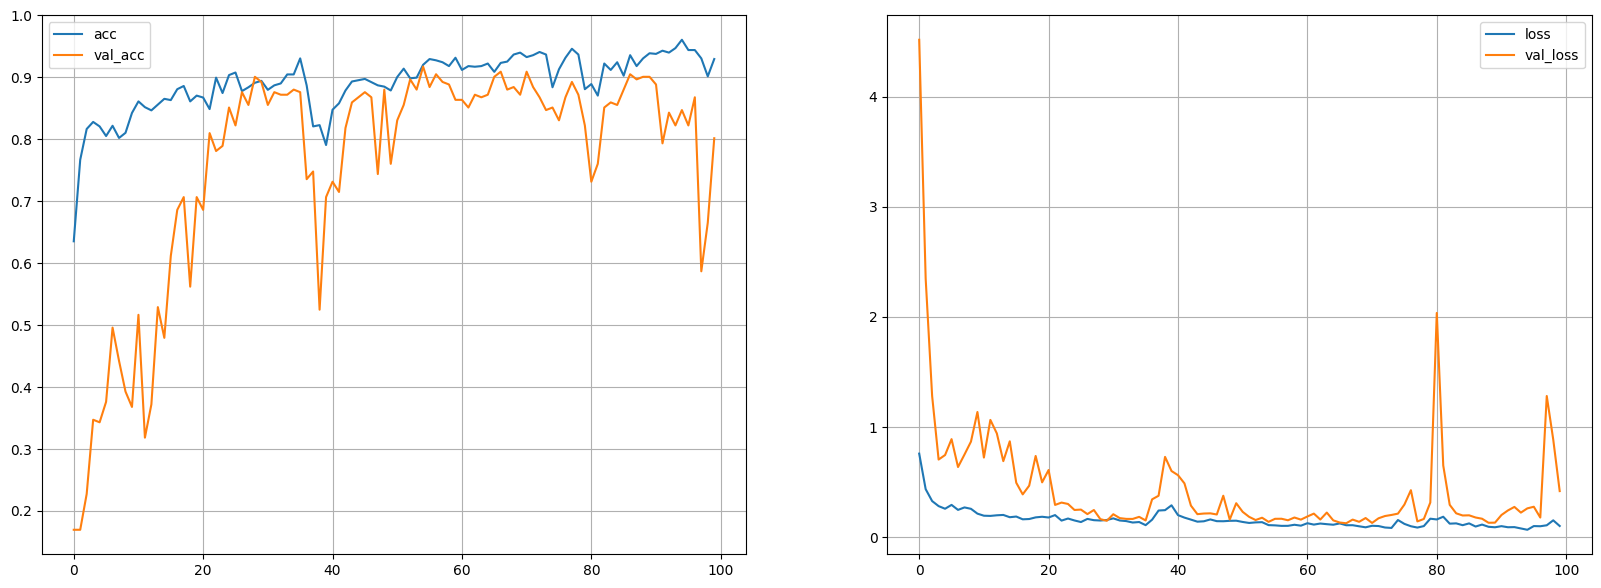

In [7]:
H = history.history
fig = plt.figure(figsize = (20, 7))
plt.subplot(121)
plt.plot(H['accuracy'], label = 'acc')
plt.plot(H['val_accuracy'], label = 'val_acc')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(H['loss'], label = 'loss')
plt.plot(H['val_loss'], label = 'val_loss')
plt.grid()
plt.legend()

In [8]:
import cv2
import imghdr
import tensorflow as tf

C:\Users\ds\AppData\Local\Temp\ipykernel_28692\3795465747.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [9]:
# Loading best weights
model.load_weights('models/best_model.keras')
# Save model for later usage
model.save('models/best_model.keras')



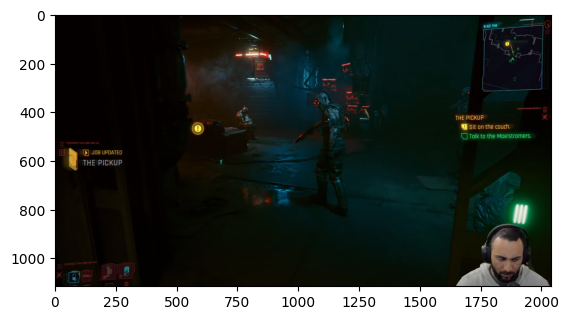

In [10]:
#test on new data
#uncomment lines below to test data
#img = cv2.imread('hsrt1.PNG')

#change this line to load image
img = cv2.imread('cbpt1.PNG')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [43]:
#resize image to throw into neural network

In [11]:
#throw into model
#put into list because model is taking batches and not taking singular lists
resized = cv.resize(img, (input_shape[1], input_shape[0]))
resized = (resized / 255.0).reshape(-1, input_shape[1], input_shape[0], input_shape[2])
yhat = model.predict(resized)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


In [12]:
preds = zip(list(mlb.classes_), list(yhat[0]))
preds = sorted(list(preds), key = lambda z: z[1], reverse = True)[:2]

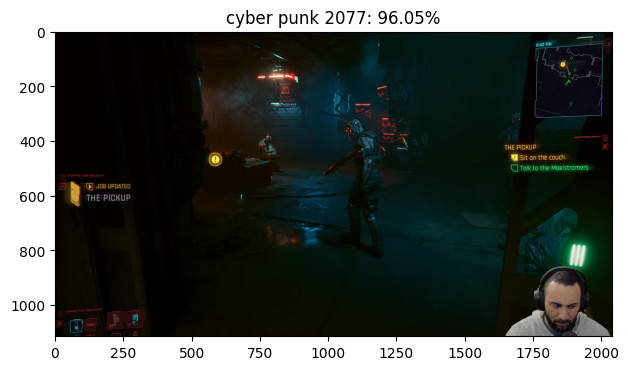

In [13]:
plt.imshow(img[:, :, ::-1])
plt.title(f'{preds[0][0]}: {round(preds[0][1] * 100, 2)}%')    
        
plt.tight_layout()